In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import glob
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as lr
from scipy.io import netcdf as nc
from pyDOE import *

## Reading in data
 * grab certain fields from every ensemble member
 * tack on forcing data only available in ens000000

In [2]:
data_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSmoupbdbEzD3q0xwzJ7u7qzGGwuKbttAdB47KtgIj9r_VkKNRCWg6tdwolIn0PbTqbKudnE2Mugk4f/pub?output=csv'
cmd = 'curl '+data_url+' > params.csv'
os.system(cmd)

data     = pd.read_csv('params.csv')
included = data['include']=='1'
params   = data.loc[included,['name','min','max','location']]

params[['min', 'max']] = params[['min', 'max']].apply(pd.to_numeric) 

In [3]:
sampling_protocol = 'LHC'

nparam = len(params['name'])  #number of parameters


if sampling_protocol == 'LHC':
    #define sample size (number of ensemble members)
    nsamp = 150
    # Generate the latin hypercube sample
    lhd = lhs(nparam, samples=int(nsamp))
    # scale according to parameter range
    param_array = ((params['max'] - params['min']).values)*lhd + params['min'].values

else:
    #nan is code for keep the default value
    ns    = 10
    nsamp = ns*nparam
    param_array = np.nan*np.ones([nsamp,nparam])
    for i in np.arange(ns):
        ix = (np.arange(i,nsamp,ns),np.arange(0,nparam,1))
        vals = params['min']+i/(ns-1)*(params['max']-params['min'])
        param_array[ix]=vals

    ot = np.arange(60)
    ix = np.logical_or(ot<20,ot>29)
    param_array=param_array[ix,:]
    param_array[:,2]=5e-10
# store in a pandas dataframe
psets = pd.DataFrame(data=param_array, index=None, columns=params['name'])
psets

name,xl,theta_ip,theta_cj,jmaxb0,jmaxb1,wc2wjb0
0,0.219133,0.963899,0.959488,0.027656,0.119790,1.444176
1,0.442370,0.954363,0.957811,0.029351,0.085373,1.221705
2,0.349445,0.965369,0.997874,0.037817,0.104913,1.229205
3,-0.255664,0.977282,0.952066,0.038261,0.230322,0.898760
4,0.362639,0.961201,0.996839,0.018396,0.133083,0.688472
5,-0.205119,0.997760,0.954381,0.024275,0.175043,1.354565
6,0.015135,0.962542,0.963850,0.017977,0.217510,1.064305
7,-0.121629,0.989247,0.975463,0.048124,0.106969,1.178761
8,-0.032133,0.976495,0.969966,0.017174,0.171099,1.313842
9,0.414293,0.965898,0.966970,0.013586,0.197991,0.865528


In [63]:
da = xr.DataArray(psets['jmaxb1'],name='jmaxb1',coords=[('ens',np.arange(150))])
da.attrs['long_name']='coefficient determining the response of electron transport rate to light availability (unitless)'
da.attrs['units']='unitless'
da.attrs['comments']='used by luna, CLM5.0 default value = 0.1'
da.to_netcdf('/glade/scratch/djk2120/UMBens/jmaxb1.nc')

# Create the parameter files

In [62]:
#create all the new parameter files, copied from basepftfile
prefix = 'US-UMB_GPPcap_'+sampling_protocol
first = 1  #in order to not overwrite old paramfiles
basepftfile = '/glade/p/cgd/tss/people/oleson/modify_param/clm5_params.c200402_kwo.c200422.nc'

for i in np.arange(nsamp):
    tmp     = xr.open_dataset(basepftfile)
    pftfile = "../paramfiles/spinme/"+prefix+str(first+i).zfill(4)+".nc"
    print(pftfile)
    for name,loc in zip(params['name'],params['location']):
        if loc!='N':
            var = tmp[name]
            if var.shape:
                tmp[name][:]=psets[name][i]
            else:
                tmp[name]=psets[name][i]
    tmp.to_netcdf(pftfile,'w')

../paramfiles/spinme/US-UMB_GPPcap_LHC0001.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0002.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0003.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0004.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0005.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0006.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0007.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0008.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0009.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0010.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0011.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0012.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0013.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0014.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0015.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0016.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0017.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0018.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0019.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0020.nc
../paramfiles/spinme/US-UMB_GPPcap_LHC0021.nc
../paramfiles/spinme/US-UMB_GPPcap

In [65]:
#create the namelist mod files
for i in range(nsamp):
    nlfile = "../namelist_mods/"+prefix+str(first+i).zfill(4)+".txt" 
    with open(nlfile,"w") as file:
        output = "! user_nl_clm namelist options written by generate_params:\n"
        file.write(output)

for name,loc in zip(params['name'],params['location']):
    if loc=='N':
        for i in range(nsamp):
            if ~np.isnan(psets[name][i]):
                nlfile = "../namelist_mods/"+prefix+str(i+1).zfill(4)+".txt"  
                with open(nlfile,"a") as file: # key is using "a" for append option
                    output = "%s=%s\n" % (name, psets[name][i]) #round??
                    file.write(output)

In [10]:
f='/glade/p/cgd/tss/people/oleson/modify_param/clm5_params.c200402_kwo.c200422.nc'
defp = xr.open_dataset(f)

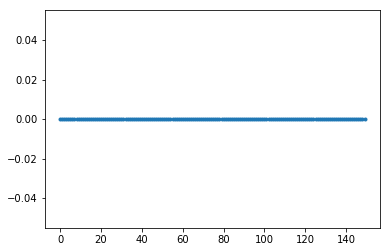

In [27]:
f = '/glade/scratch/djk2120/UMBens/jmaxb1.nc'
jm = xr.open_dataset(f)
plt.plot(psets['jmaxb1']-jm['jmaxb1'],'.')

In [66]:
psets['jmaxb1'][99]

0.20685774112998573